In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


from lightgbm import LGBMClassifier
import gc
import os
import re
import json

%aimport src.utils.plot
%aimport src.utils
%aimport src.feats

import src.utils as utils
import src.feats as feats



# %afrom src.utils import utils
# %afrom src.feats import feats

In [3]:
 train = utils.read_csv('./input/application_train.csv')
 test = utils.read_csv('./input/application_test.csv')
 prev = utils.read_csv('./input/previous_application.csv')
 buro = utils.read_csv('./input/bureau.csv')

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%


In [4]:
feats.app_features(train)
feats.app_features(test)

In [5]:
categorical_feats = [
    f for f in train.columns if train[f].dtype == 'object'
]
categorical_feats

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE']

In [6]:
for f in categorical_feats:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

In [7]:
gc.enable()

In [8]:
y = train['TARGET']
del train['TARGET']

In [9]:
# prev_cat_features = [
#     f_ for f_ in prev.columns if prev[f_].dtype == 'object'
# ]
# for f_ in prev_cat_features:
#     prev[f_], _ = pd.factorize(prev[f_])

In [10]:
prev['X_HOUR_APPR_PROCESS_START'] = prev['HOUR_APPR_PROCESS_START'].astype(str)
del prev['HOUR_APPR_PROCESS_START']

prev_cat_features = [
    f_ for f_ in prev.columns if prev[f_].dtype == 'object'
]
prev_dum = pd.DataFrame()
for f_ in prev_cat_features:
    prev_dum = pd.concat([prev_dum, pd.get_dummies(prev[f_], prefix=f_).astype(np.uint8)], axis=1)

prev = pd.concat([prev, prev_dum], axis=1)

del prev_dum
gc.collect()

133

In [11]:
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['X_NB_APP'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']

In [12]:
feats.prev_features(avg_prev)

In [13]:
buro_cat_features = [
    f_ for f_ in buro.columns if buro[f_].dtype == 'object'
]
buro_dum = pd.DataFrame()
for f_ in buro_cat_features:
    buro_dum = pd.concat([buro_dum, pd.get_dummies(buro[f_], prefix=f_).astype(np.uint8)], axis=1)

buro = pd.concat([buro, buro_dum], axis=1)

In [14]:
# buro_cat_features = [
#     f_ for f_ in buro.columns if buro[f_].dtype == 'object'
# ]
# for f_ in buro_cat_features:
#     buro[f_], _ = pd.factorize(buro[f_])

avg_buro = buro.groupby('SK_ID_CURR').mean()
avg_buro['X_BURO_COUNT'] = buro[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
del avg_buro['SK_ID_BUREAU']

In [15]:
pos = utils.read_csv('./input/POS_CASH_balance.csv')
pos = pd.concat([pos, pd.get_dummies(pos['NAME_CONTRACT_STATUS'])], axis=1)
nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
avg_pos = pos.groupby('SK_ID_CURR').mean()

del pos, nb_prevs
gc.collect()

cc_bal = utils.read_csv('./input/credit_card_balance.csv')
cc_bal = pd.concat([cc_bal, pd.get_dummies(cc_bal['NAME_CONTRACT_STATUS'])], axis=1)

nb_prevs = cc_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
cc_bal['SK_ID_PREV'] = cc_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

avg_cc_bal = cc_bal.groupby('SK_ID_CURR').mean()

del cc_bal, nb_prevs
gc.collect()

inst = utils.read_csv('./input/installments_payments.csv')
nb_prevs = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
inst['SK_ID_PREV'] = inst['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

avg_inst = inst.groupby('SK_ID_CURR').mean()
del inst
gc.collect()

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


14

In [16]:
avg_prev.columns = ['prev_{}'.format(c) for c in avg_prev.columns]
avg_buro.columns = ['buro_{}'.format(c) for c in avg_buro.columns]
avg_inst.columns = ['inst_{}'.format(c) for c in avg_inst.columns]
avg_pos.columns = ['pos_{}'.format(c) for c in avg_pos.columns]
avg_cc_bal.columns = ['cc_bal_{}'.format(c) for c in avg_cc_bal.columns]

train = train.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
train = train.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
train = train.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
train = train.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
train = train.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

In [17]:
excluded_feats = ['SK_ID_CURR']
excluded_feats = sum(list(map(lambda c: [c, f"{c}_x", f"{c}_y"], excluded_feats)), [])
features = [f_ for f_ in train.columns if f_ not in excluded_feats]
features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE'

In [18]:
# trn_x, val_x, trn_y, val_y = train_test_split(train[features], y,  test_size=0.2, random_state=42)

In [19]:
# params = {
#     'n_estimators': 4000,
#     'learning_rate': 0.01,
#     'num_leaves': 63,
#     'colsample_bytree': .8,
#     'subsample': .8,
#     'subsample_freq': 5,
#     'max_depth': 5,
#     'reg_alpha': .001,
#     'reg_lambda': .1,
#     'min_split_gain': .01,
#     'device': "gpu",
# #     'categorical_feature': 'name:CODE_GENDER'
# }


# clf = LGBMClassifier(**params)

# eval_set = [(trn_x, trn_y), (val_x, val_y)]

# %time clf.fit(trn_x, trn_y, eval_set=eval_set, eval_metric='auc', verbose=250, early_stopping_rounds=150)

# trn_preds = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]
# val_preds = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
# test_preds = clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1]

# trn_auc = roc_auc_score(trn_y, trn_preds)
# auc = roc_auc_score(val_y, val_preds)
# print('AUC : %.6f' % auc)
# gc.collect()

# config = {
#     'model': 'lgbm',
#     'params': params,
#     'trn_auc': trn_auc,
#     'auc': auc,
#     'features': features
# }

In [20]:
# folds = KFold(n_splits=5, shuffle=True, random_state=42)
# oof_preds = np.zeros(train.shape[0])
# test_preds = np.zeros(test.shape[0])
# val_aucs = []

# params = {
#   'n_estimators': 4000,
#   'learning_rate': 0.01,
#   'num_leaves': 63,
#   'colsample_bytree': .8,
#   'subsample': .8,
#   'subsample_freq': 5,
#   'max_depth': 5,
#   'reg_alpha': .001,
#   'reg_lambda': .1,
#   'min_split_gain': .01,
#   'device': "gpu",
# }
    

# for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train)):
#     trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
#     val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]

#     clf = LGBMClassifier(**params)
#     clf.fit(trn_x, trn_y, 
#             eval_set= [(trn_x, trn_y), (val_x, val_y)], 
#             eval_metric='auc', verbose=250, early_stopping_rounds=150
#            )
    
#     oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
#     test_preds += clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
#     val_auc = roc_auc_score(val_y, oof_preds[val_idx])
#     print('Fold %2d AUC : %.6f' % (n_fold + 1, val_auc))
#     val_aucs.append(val_auc)
#     del clf, trn_x, trn_y, val_x, val_y
#     gc.collect()

# trn_auc = roc_auc_score(y, oof_preds)
# print('Full AUC score %.6f' % trn_auc)
# auc = np.array(val_aucs).mean()

# config = {
#     'model': 'lgbm',
#     'params': params,
#     'trn_auc': trn_auc,
#     'auc': auc,
# }

In [21]:
test_preds = np.zeros(test.shape[0])
trn_aucs = []
aucs = []
random_states = [1, 42]

for i in range(0, 2):
    trn_x, val_x, trn_y, val_y = train_test_split(train[features], y,  test_size=0.2, random_state=random_states[i])
    
    params = {
      'n_estimators': 4000,
      'learning_rate': 0.01,
      'num_leaves': 63,
      'colsample_bytree': .8,
      'subsample': .8,
      'subsample_freq': 5,
      'max_depth': 5,
      'reg_alpha': .001,
      'reg_lambda': .1,
      'min_split_gain': .01,
      'device': "gpu",
    }

    clf = LGBMClassifier(**params)

    eval_set = [(trn_x, trn_y), (val_x, val_y)]
    %time clf.fit(trn_x, trn_y, eval_set=eval_set, eval_metric='auc', verbose=250, early_stopping_rounds=150)

    trn_preds = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]
    val_preds = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    test_preds += clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1]

    trn_auc = roc_auc_score(trn_y, trn_preds)
    auc = roc_auc_score(val_y, val_preds)
    print('Iter %d AUC : %.6f' % (i+1, auc))
    trn_aucs.append(trn_auc)
    aucs.append(auc)

    del trn_x, val_x, trn_y, val_y
    gc.collect()

test_preds = test_preds/2
trn_auc = np.array(trn_aucs).mean()
auc = np.array(aucs).mean()
print('AUC train_auc %.6f val_auc %.6f' % (trn_auc, auc))

config = {
    'model': 'lgbm',
    'params': params,
    'trn_auc': trn_auc,
    'auc': auc,
}

Training until validation scores don't improve for 150 rounds.
[250]	training's auc: 0.774474	valid_1's auc: 0.766469
[500]	training's auc: 0.79581	valid_1's auc: 0.780034
[750]	training's auc: 0.808795	valid_1's auc: 0.785422
[1000]	training's auc: 0.818814	valid_1's auc: 0.788178
[1250]	training's auc: 0.826897	valid_1's auc: 0.789822
[1500]	training's auc: 0.834315	valid_1's auc: 0.790732
[1750]	training's auc: 0.840642	valid_1's auc: 0.791441
[2000]	training's auc: 0.846993	valid_1's auc: 0.792053
[2250]	training's auc: 0.852542	valid_1's auc: 0.79253
[2500]	training's auc: 0.857818	valid_1's auc: 0.7929
[2750]	training's auc: 0.863257	valid_1's auc: 0.793318
[3000]	training's auc: 0.868227	valid_1's auc: 0.793377
[3250]	training's auc: 0.873245	valid_1's auc: 0.793576
Early stopping, best iteration is:
[3334]	training's auc: 0.874731	valid_1's auc: 0.793651
CPU times: user 18min 20s, sys: 3.52 s, total: 18min 24s
Wall time: 4min 55s
Iter 1 AUC : 0.793651
Training until validation 

In [22]:
utils.save_result(
    test=test,
    test_preds=test_preds,
    config=config,
    features=features,
    clf=clf
)

Save to ./experiments/047-lgbm-0.790544.csv


In [23]:
train['X_OCCUPATION_TYPE']

0                      Laborers
1                    Core staff
2                      Laborers
3                      Laborers
4                    Core staff
5                      Laborers
6                   Accountants
7                      Managers
8                           NaN
9                      Laborers
10                   Core staff
11                          NaN
12                     Laborers
13                      Drivers
14                     Laborers
15                     Laborers
16                      Drivers
17                     Laborers
18                     Laborers
19                   Core staff
20                     Laborers
21                  Sales staff
22                  Sales staff
23                          NaN
24                      Drivers
25               Cleaning staff
26                Cooking staff
27                     Laborers
28                          NaN
29                     Laborers
                  ...          
307481  

In [24]:
reg = re.compile(r"(.*_)?X_")
handmade_features = [x for x in features if reg.match(x)]
for f in handmade_features:
    print('{}: {}'.format(f, clf.feature_importances_[features.index(f)]))


X_AMT_LOAN_PERIOD: 2219
X_AMT_GOODS_RATIO: 1080
X_HOUR_APPR_PROCESS_START: 2267
X_OCCUPATION_TYPE: 1533
prev_X_HOUR_APPR_PROCESS_START_0: 18
prev_X_HOUR_APPR_PROCESS_START_1: 5
prev_X_HOUR_APPR_PROCESS_START_10: 228
prev_X_HOUR_APPR_PROCESS_START_11: 236
prev_X_HOUR_APPR_PROCESS_START_12: 169
prev_X_HOUR_APPR_PROCESS_START_13: 296
prev_X_HOUR_APPR_PROCESS_START_14: 239
prev_X_HOUR_APPR_PROCESS_START_15: 264
prev_X_HOUR_APPR_PROCESS_START_16: 204
prev_X_HOUR_APPR_PROCESS_START_17: 189
prev_X_HOUR_APPR_PROCESS_START_18: 173
prev_X_HOUR_APPR_PROCESS_START_19: 181
prev_X_HOUR_APPR_PROCESS_START_2: 27
prev_X_HOUR_APPR_PROCESS_START_20: 113
prev_X_HOUR_APPR_PROCESS_START_21: 54
prev_X_HOUR_APPR_PROCESS_START_22: 19
prev_X_HOUR_APPR_PROCESS_START_23: 7
prev_X_HOUR_APPR_PROCESS_START_3: 99
prev_X_HOUR_APPR_PROCESS_START_4: 104
prev_X_HOUR_APPR_PROCESS_START_5: 76
prev_X_HOUR_APPR_PROCESS_START_6: 79
prev_X_HOUR_APPR_PROCESS_START_7: 220
prev_X_HOUR_APPR_PROCESS_START_8: 254
prev_X_HOUR_APPR_PR

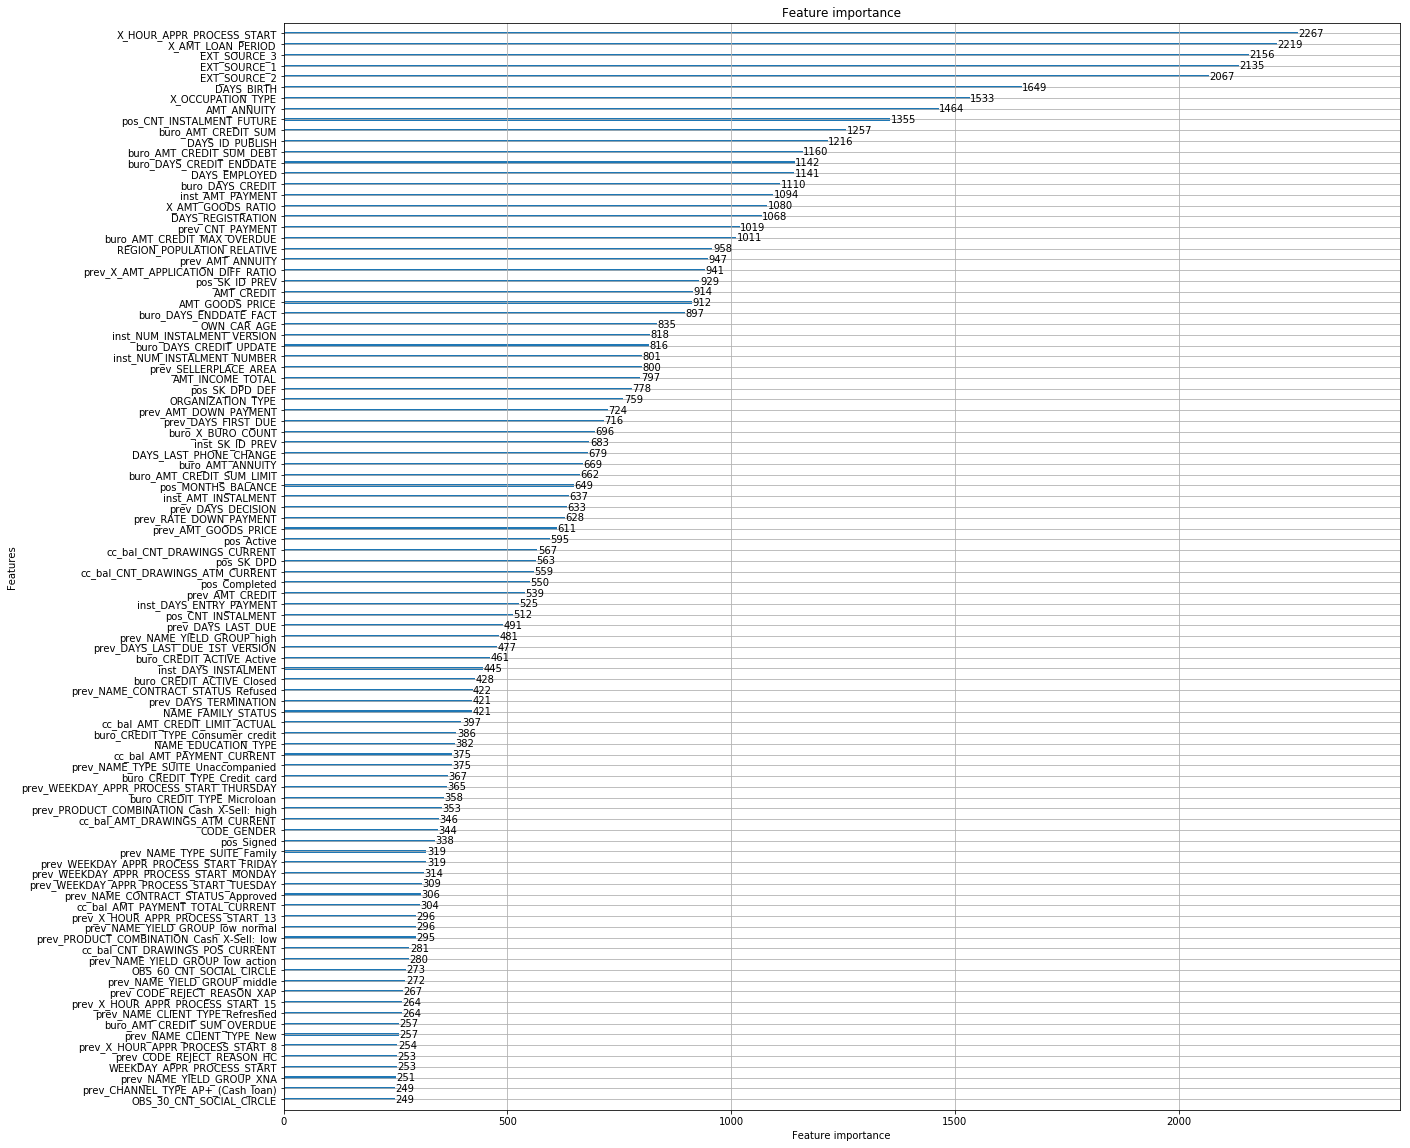

In [25]:
import lightgbm.plotting

lightgbm.plotting.plot_importance(clf, max_num_features=100, figsize=(20, 20))